In [1]:
import numpy as np
import pandas as pd
import random
import plotly.express as px
from yahoo_fin.stock_info import *
import matplotlib.pyplot as plt
from collections import deque

In [2]:
MRKT = 'QQQ'
PRDC = 'XLI'
METL = 'DBB'
NRES = 'IGE'
DEBT = 'SHY'
USDX = 'UUP'
GOLD = 'GLD'
SLVA = 'SLV'
UTIL = 'XLU'
INDU = PRDC
SPY = 'SPY'
QQQ = MRKT
BOND = 'TLT'

SIGNALS = [PRDC, METL, NRES, USDX, DEBT, MRKT]
FORPAIRS = [GOLD, SLVA, UTIL, INDU]
PAIRLIST = ['G_S', 'U_I']
BASKET_IN = ['QQQ']
BASKET_OUT = ['TLT', 'IEF', 'SPDN']

LOOKBACK = 252*5
INI_WAIT_DAYS = 15
be_in = [1]
global dcount
dcount = 0
global outday
outday = 0

ALL_SYMBOLS = list(SIGNALS + [MRKT] + FORPAIRS + [SPY] + [BOND])

In [3]:
df_data = {}
for stock_ticker in ALL_SYMBOLS: 
    data = get_data(stock_ticker)
    adj_closed = data['close'][- (LOOKBACK + 4000):]
    df_data[stock_ticker] = adj_closed
data = pd.DataFrame(df_data).dropna()

In [4]:
date = []
in_out = []
benchmark = []
bonds = []

def analyze(history):
    global dcount
    global outday
    global date
    global in_out
    global benchmark
    global bonds
    
    history_shift = history.rolling(11, center=True).mean().shift(60)
    returns_sample = (history / history_shift - 1)
    # Reverse code USDX: sort largest changes to bottom
    returns_sample[USDX] = returns_sample[USDX] * (-1)
    # For pairs, take returns differential, reverse coded
    returns_sample['G_S'] = -(returns_sample[GOLD] - returns_sample[SLVA])
    returns_sample['U_I'] = -(returns_sample[UTIL] - returns_sample[INDU])
    # Extreme observations; statistical significance = X% (stat_alpha)
    extreme_b = returns_sample.iloc[-1] < np.nanpercentile(returns_sample, 5, axis=0)

    # Re-assess/disambiguate double-edged signals
    abovemedian = returns_sample.iloc[-1] > np.nanmedian(returns_sample, axis=0)
    ### Interest rate expectations (cost of debt) may increase because the economic outlook improves (showing in rising input prices) = actually not a negative signal
    extreme_b.loc[DEBT] = np.where((extreme_b.loc[DEBT].any()) & (abovemedian[[METL, NRES]].any()), False, extreme_b.loc[DEBT])

    if (extreme_b[SIGNALS + PAIRLIST]).any():
        be_in.append(0)
        outday = dcount
    if dcount >= outday + INI_WAIT_DAYS:
        be_in.append(1)
        
    date.append(history.iloc[-1].name)
    in_out.append(be_in[-1])
    benchmark.append(history['SPY'].iloc[-1])
    bonds.append(history['TLT'].iloc[-1])
    
    dcount += 1

In [5]:
for i in range(-1000, 0): 
    analyze(data[:(i)][-LOOKBACK:])

In [6]:
df_dict = {
    'date': date, 
    'in_out': in_out, 
    'SPY': benchmark, 
    'TLT': bonds
}
master = pd.DataFrame(df_dict)
master = master.set_index('date')

In [7]:
master

,in_out,SPY,TLT
date,,,
2018-01-03,1,270.470001,126.089996
2018-01-04,1,271.609985,126.070000
2018-01-05,1,273.420013,125.709999
2018-01-08,1,273.920013,125.629997
2018-01-09,1,274.540009,123.949997
...,...,...,...
2021-12-15,0,470.600006,149.250000
2021-12-16,1,466.450012,149.139999
2021-12-17,1,459.869995,150.830002


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

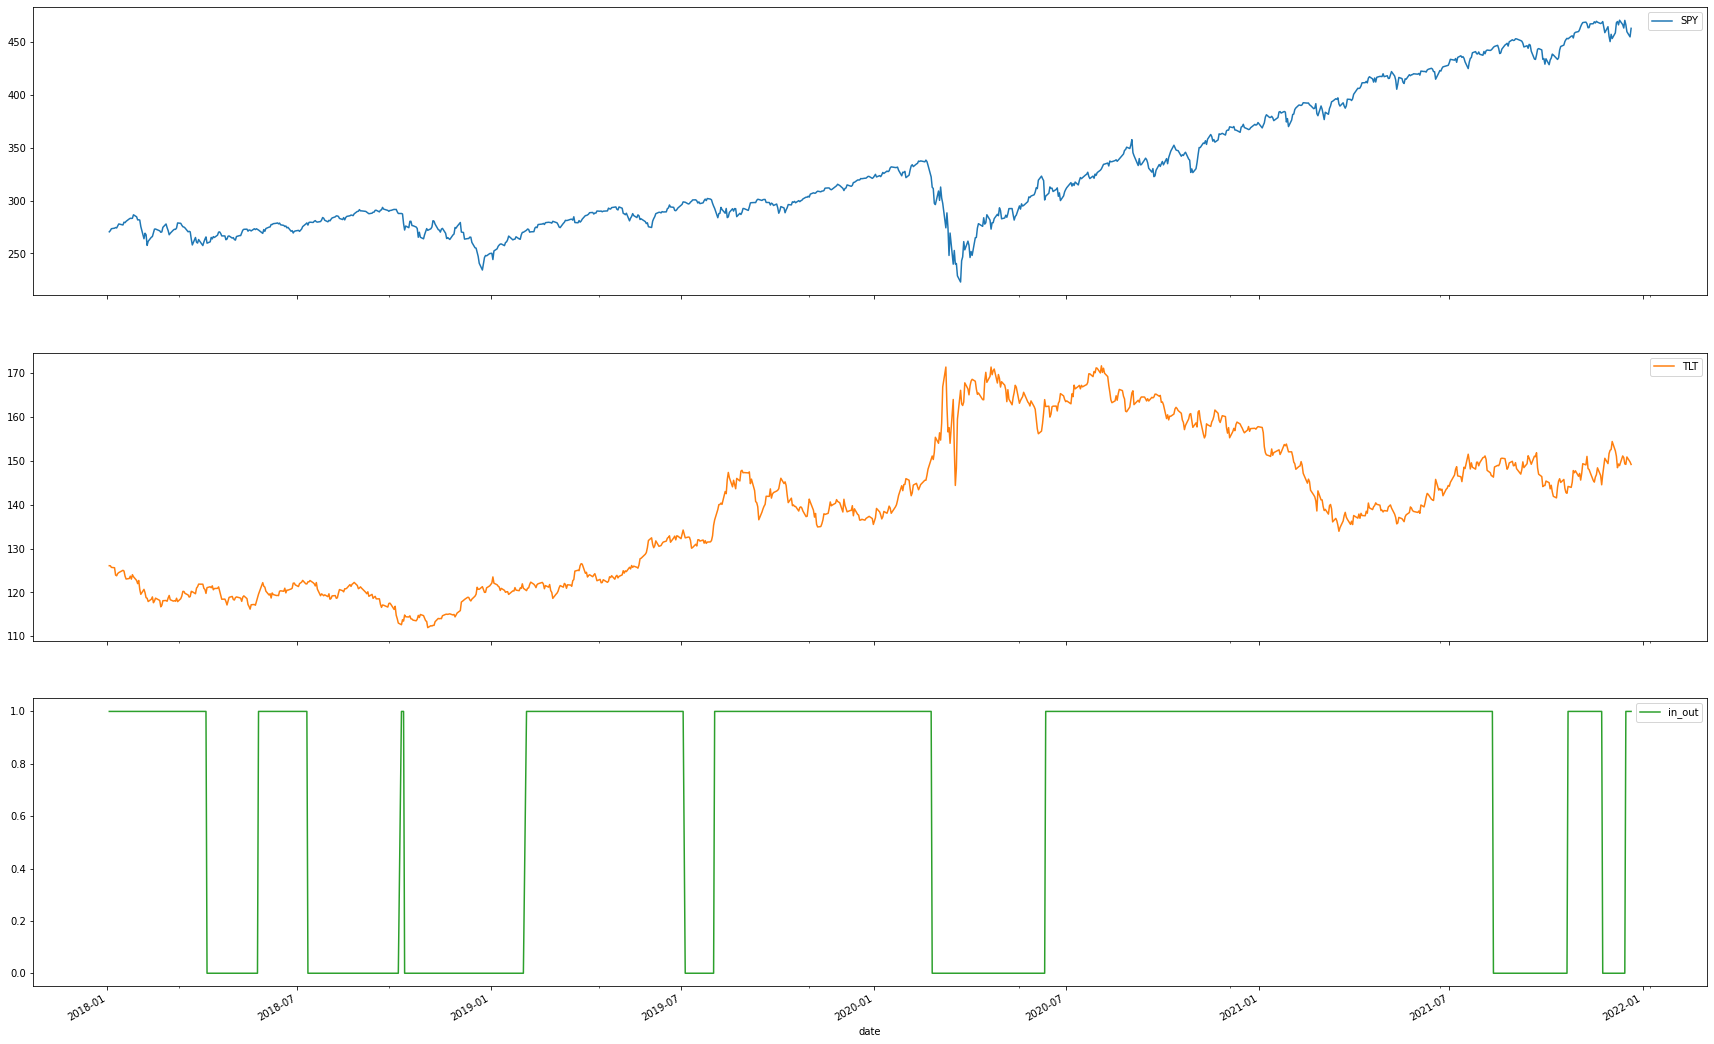

In [8]:
master[['SPY', 'TLT', 'in_out']].plot(subplots=True, figsize=(30,20))

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

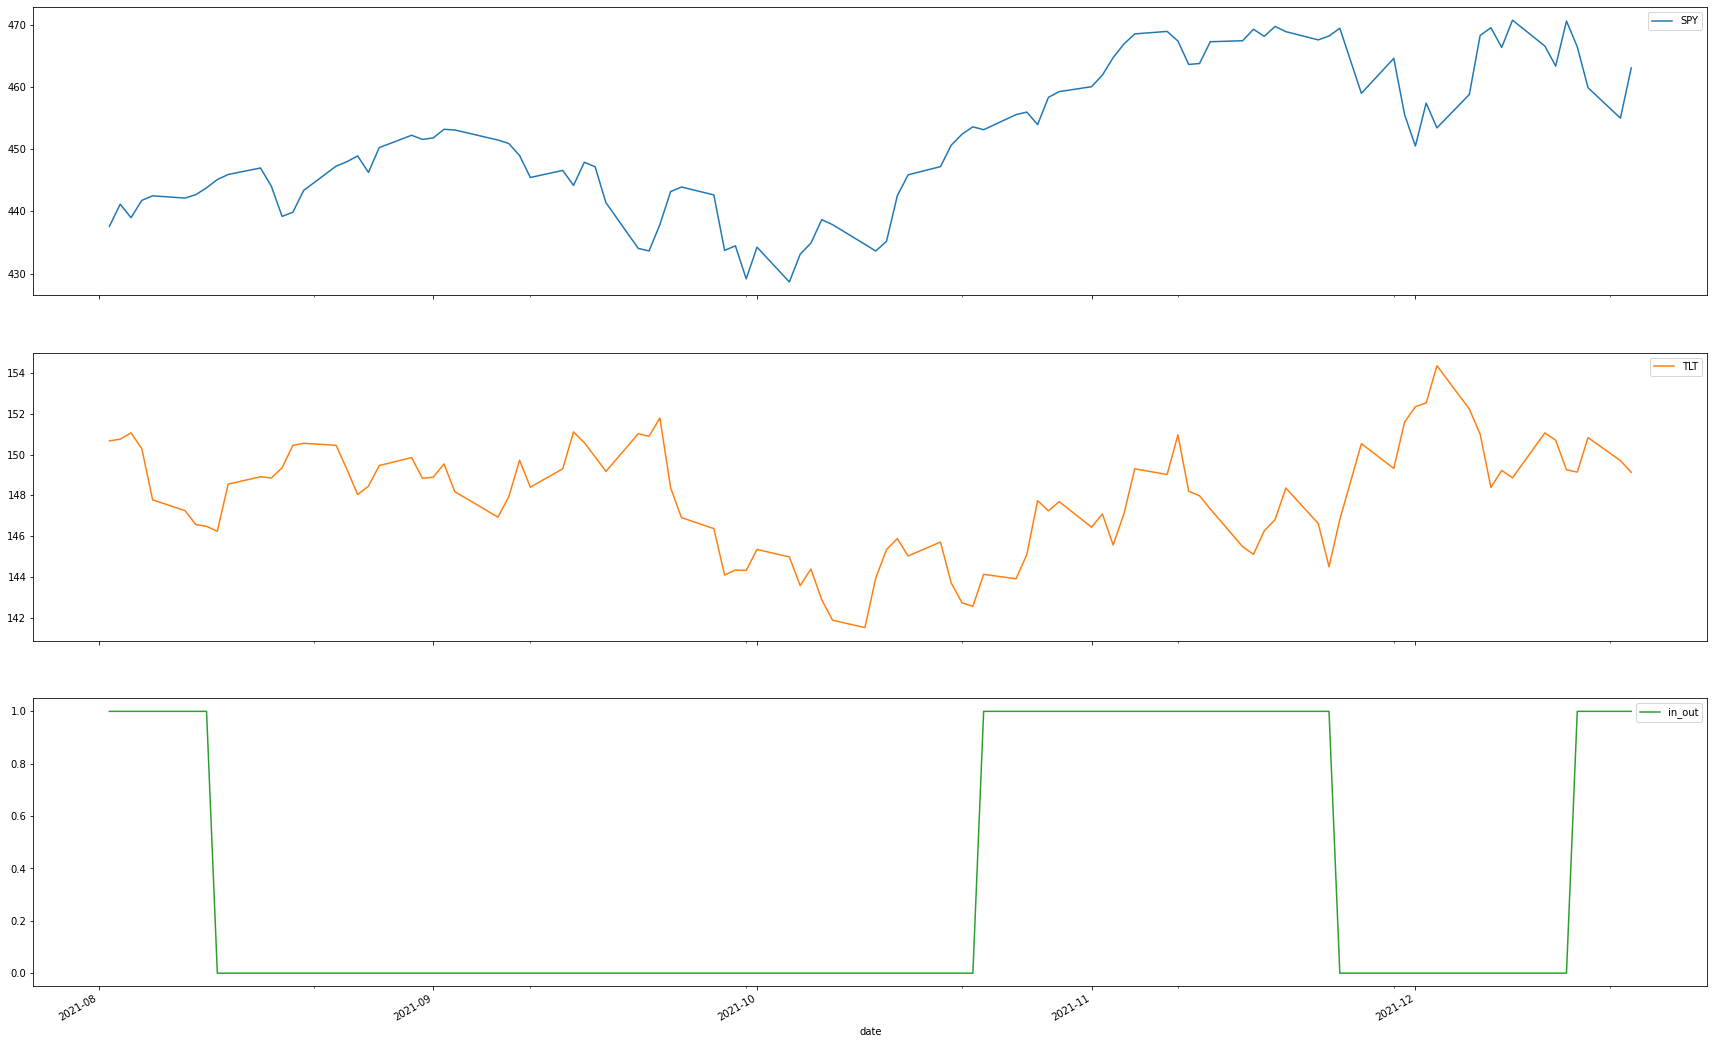

In [15]:
master[-100:][['SPY', 'TLT', 'in_out']].plot(subplots=True, figsize=(30,20))